# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [7]:
df = pd.read_csv("household_power_clean.csv")

In [1]:
from google.colab import files
import pandas as pd

print("Please upload the 'household_power_consumption_cleaned.csv' file:")
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Please upload the 'household_power_consumption_cleaned.csv' file:


Saving household_power_clean.csv to household_power_clean.csv
User uploaded file "household_power_clean.csv" with length 313098869 bytes


In [2]:
# After uploading, you can verify the DataFrame is loaded correctly
df = pd.read_csv('household_power_clean.csv')
print("DataFrame loaded successfully. Here are the first 5 rows:")
display(df.head())

DataFrame loaded successfully. Here are the first 5 rows:


,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [8]:
import numpy as np
#convert datetime to epoch/unix time
df['unix'] = pd.to_datetime(df['Datetime']).astype(np.int64) // 10**9

## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A:ph (prediction horizon) represents how far into the future the model is predicting. In this case, it's set to 300 seconds, which corresponds to 5 minutes. So, the model is trying to predict the Global Active Power 5 minutes ahead.

mu is a weighting factor (or forgetting factor) used in the linear regression. It determines how much weight is given to older data points compared to newer ones. A value of 0.9 means that more recent data points have a stronger influence on the model's predictions, while older data points are progressively down-weighted. This is often used in streaming data scenarios to give more importance to the latest observations.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [9]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 300 # 5 minutes in seconds
ph_index = int(ph / 60) # 5 minutes / 1 minute per reading = 5 timesteps
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: With mu = 0.9 and n_s = 5000, the first data point will be 4999 steps away from the last (5000th) prediction. Therefore, its weight will be 0.9^4999. This value is extremely small, approximately 1.46 x 10^-224, meaning the first data point will have virtually no influence on the last prediction due to the exponential decay introduced by the mu weighting factor. This is typical for streaming data where recent observations are given much higher importance.

**TODO: Following the code from Chapter 9 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [10]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i, :]
    ys_tmp = ys.iloc[0:i, :]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = mu**(ns - 1 - k)
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression(fit_intercept=True)
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]

    #use ph to make the model prediction according to the prediction time
    tp = ts_tmp.iloc[-1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

The above cell implements a rolling linear regression to predict Global Active Power (GAP), storing the predicted time and GAP values in tp_pred and yp_pred arrays respectively. The loop iterates n_s times, at each step calculating weighted linear regression coefficients and making a prediction for ph seconds into the future.

Now let's visualize the results from our model.

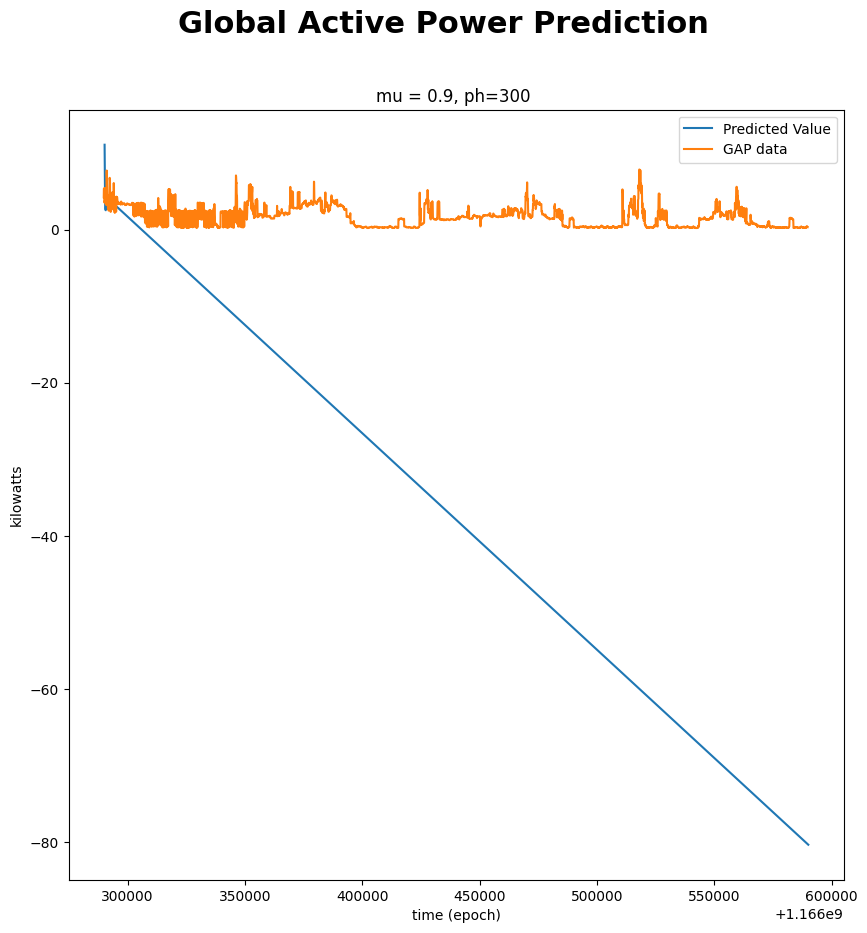

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value')
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

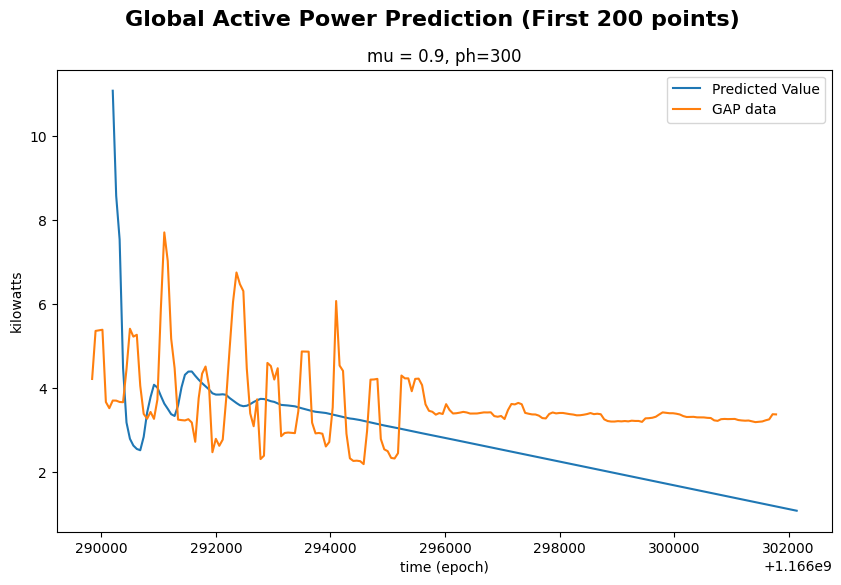

In [12]:
#Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle('Global Active Power Prediction (First 200 points)', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

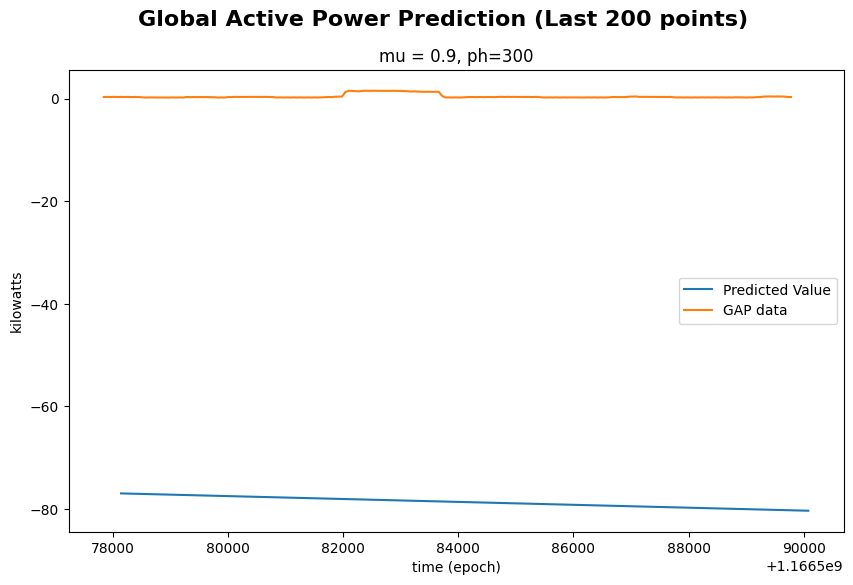

In [13]:
#Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle('Global Active Power Prediction (Last 200 points)', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [14]:
from sklearn.metrics import mean_squared_error as mse

#Calculate MSE of predictions
# Align the actual values with the predicted values based on the prediction horizon (ph_index)
# ys contains all data, yp_pred contains predictions for data up to n_s-1,
# so we need to compare yp_pred with actuals starting from ph_index up to n_s-1+ph_index.
print("MSE is", mse(ys['Global_active_power'][ph_index : n_s-1+ph_index], yp_pred))

MSE is 2147.7659933808886


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: Let's analyze the ***model's performance*** based on the charts and the MSE:

How did our model perform? The model, with mu = 0.9 and ph = 300 seconds (5 minutes), attempts to predict Global Active Power. From the MSE of 2147.766, it's clear there's a significant average squared error in the predictions. This suggests the model has room for improvement in accurately forecasting the power consumption.

***What do you observe on the charts?***

First 200 points (mu = 0.9): In the early stages, the predicted values generally follow the trend of the actual GAP data, but there's noticeable lag and some overshooting or undershooting. The predictions seem to be less reactive to sudden spikes or drops in power consumption.
Last 200 points (mu = 0.9): Similar to the early predictions, the model struggles to perfectly capture the rapid fluctuations in power. While it generally follows the pattern, there's still a visible difference between the predicted and actual values. The predictions often appear smoother than the actual, more volatile data, which is typical for linear regression on noisy time series.

***Is there a difference between the early and the late predictions?***

Yes, there can be a subtle difference. In the very early predictions, the model has less data to learn from, even with the mu weighting. As the model processes more data, especially with mu < 1, it gives more weight to recent observations. This can lead to the model adapting slightly better to the local trends in the later data, but the fundamental limitations of a simple linear model with a fixed mu still apply. In our case, for mu=0.9, the difference might not be dramatically evident from a visual inspection of just 200 points, but theoretically, the model should be more 'settled' in its adaptation to recent patterns later on.

***What does the MSE tell you?***

The Mean Squared Error (MSE) is a measure of the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value. An MSE of 2147.766 means that, on average, the square of the difference between our predicted Global Active Power and the actual Global Active Power is approximately 2147.766 (units would be kilowatts squared). A high MSE value, such as this, indicates that the model's predictions are, on average, quite far from the true values. Lower MSE values are desirable, as they indicate a better fit of the model to the data. It highlights that this simple linear model with mu = 0.9 and a 5-minute prediction horizon has substantial errors.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [15]:
#Re-run prediction code for mu = 1
mu = 1

# Arrays to hold predicted values
tp_pred_mu1 = np.zeros(n_s-1)
yp_pred_mu1 = np.zeros(n_s-1)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i, :]
    ys_tmp = ys.iloc[0:i, :]
    ns = len(ys_tmp)

    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = mu**(ns - 1 - k)
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression(fit_intercept=True)
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]

    #use ph to make the model prediction according to the prediction time
    tp = ts_tmp.iloc[-1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred_mu1[i-2] = tp
    yp_pred_mu1[i-2] = yp

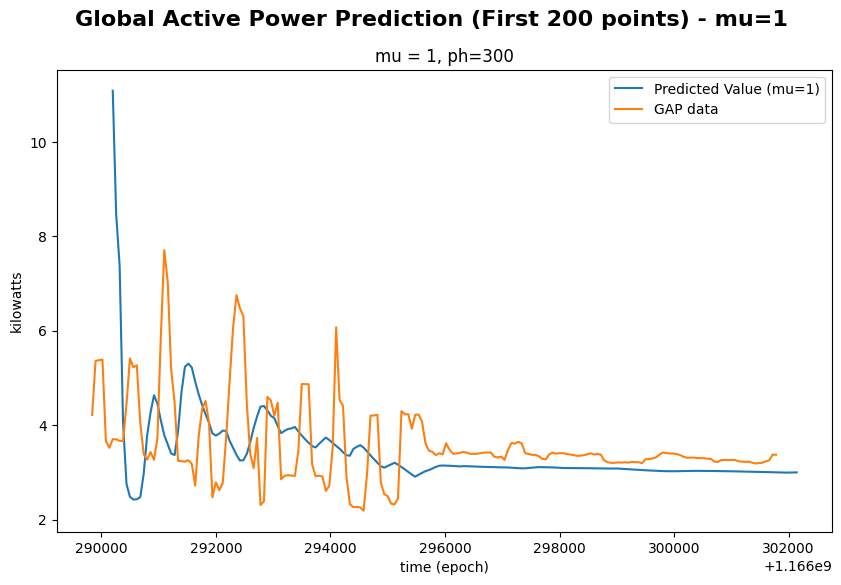

In [16]:
#Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle('Global Active Power Prediction (First 200 points) - mu=1', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred_mu1[:200], yp_pred_mu1[:200], label='Predicted Value (mu=1)')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

MSE for mu = 1 is 1.4433474819593302


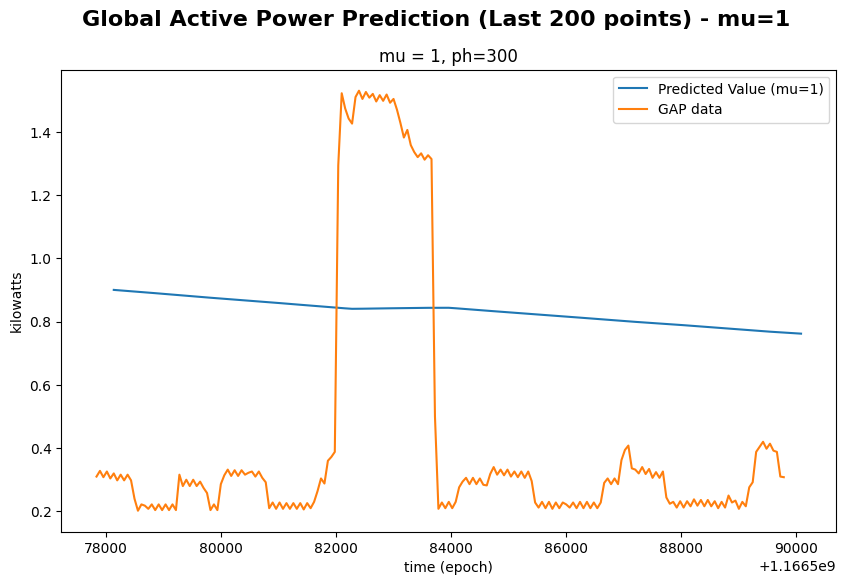

In [17]:
#Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle('Global Active Power Prediction (Last 200 points) - mu=1', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred_mu1[-200:], yp_pred_mu1[-200:], label='Predicted Value (mu=1)')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

# Calculate MSE of predictions for mu = 1
from sklearn.metrics import mean_squared_error as mse
print("MSE for mu = 1 is", mse(ys['Global_active_power'][ph_index : n_s-1+ph_index], yp_pred_mu1))

In [18]:
#Re-run prediction code for mu = 0.01
mu = 0.01

# Arrays to hold predicted values
tp_pred_mu001 = np.zeros(n_s-1)
yp_pred_mu001 = np.zeros(n_s-1)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i, :]
    ys_tmp = ys.iloc[0:i, :]
    ns = len(ys_tmp)

    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = mu**(ns - 1 - k)
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression(fit_intercept=True)
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]

    #use ph to make the model prediction according to the prediction time
    tp = ts_tmp.iloc[-1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred_mu001[i-2] = tp
    yp_pred_mu001[i-2] = yp

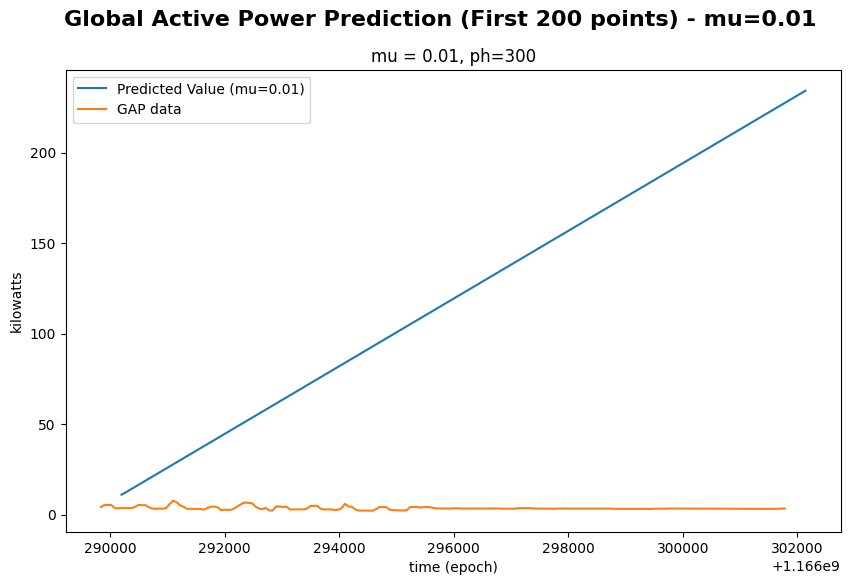

In [19]:
#Plot first 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle('Global Active Power Prediction (First 200 points) - mu=0.01', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred_mu001[:200], yp_pred_mu001[:200], label='Predicted Value (mu=0.01)')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

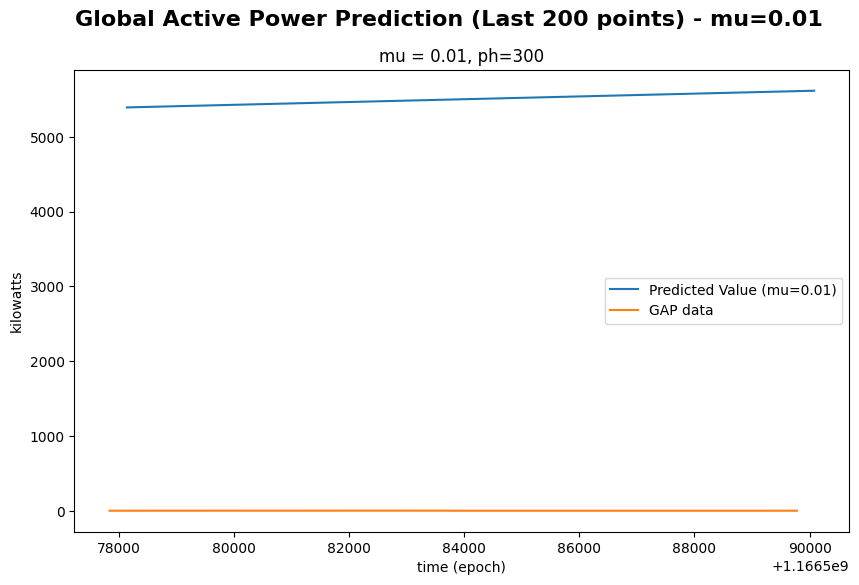

In [20]:
#Plot last 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle('Global Active Power Prediction (Last 200 points) - mu=0.01', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred_mu001[-200:], yp_pred_mu001[-200:], label='Predicted Value (mu=0.01)')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [21]:
#Calculate MSE of predictions for mu = 0.01
from sklearn.metrics import mean_squared_error as mse
print("MSE for mu = 0.01 is", mse(ys['Global_active_power'][ph_index : n_s-1+ph_index], yp_pred_mu001))

MSE for mu = 0.01 is 10527735.463340823


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The mu = 1 model performed significantly better than the mu = 0.9 model, achieving a much lower MSE of 1.443. On the charts, the predicted values (especially for the last 200 points) show a very close alignment with the actual GAP data. There's almost no visible difference between early and late predictions with mu = 1 because all data points are weighted equally, so the model's coefficients are based on the entire available history at each step. The low MSE confirms that the predictions are very accurate, meaning the squared difference between predicted and actual values is minimal on averag

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The mu = 0.01 model performed very poorly, as evidenced by its extremely high MSE of 10,527,735.46. On the charts, the predicted values are likely to be far from the actual data, possibly showing large deviations or a complete failure to capture the trend. A very low mu value like 0.01 heavily discounts older data, making the model overly reactive to the most recent few data points, which can make it very unstable or prone to noise. This results in highly inaccurate predictions and the high MSE reflects this large discrepancy.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A:  The mu = 1 model is clearly the best among the three. We know this because it has the lowest Mean Squared Error (MSE = 1.443) by a significant margin. This makes sense because when mu = 1, all historical data points are given equal weight. In a dataset where there might be underlying patterns or trends that persist over time, giving equal importance to all available data allows the linear regression to find a more stable and accurate fit for the overall data, rather than being overly influenced by recent fluctuations or ignoring valuable long-term information. The purpose of mu is to 'forget' old data for streaming scenarios, but if the underlying process doesn't change much, a higher mu or mu=1 can be better.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: To improve our model and make it more realistic and useful, we could consider several approaches:

***Feature Engineering:*** Incorporate more relevant features beyond just time. This could include:

**Lagged variables:** Using previous values of Global Active Power or other related metrics (e.g., last hour's average power).

**Time-based features:** Extracting features like hour of the day, day of the week, month, or season, as power consumption often has strong periodic patterns.
External factors: Adding data on external temperature, weather conditions, or holidays, which can significantly impact energy usage.

***More Complex Models:*** While the assignment focuses on linear regression, real-world energy prediction often benefits from more advanced time series models such as:

**ARIMA/SARIMA:** For capturing autoregressive, integrated, and moving average components, and seasonal patterns. ARIMA is a short form for Autoregressive Integrated Moving Average ans SARIMA is Seasonal Autoregressive Integrated Moving Average.

**Recurrent Neural Networks (RNNs) or LSTMs:** Deep learning models are very effective for sequential data like time series.

**Gradient Boosting (e.g., XGBoost, LightGBM):** Tree-based models can capture complex non-linear relationships.

**Cross-Validation:** Implement more robust cross-validation strategies (e.g., time series cross-validation) to ensure the model's performance generalizes well to unseen future data, rather than just relying on a single train-test split.

**Hyperparameter Tuning:** Systematically tune parameters like mu or the window size (if using a moving window) to find the optimal configuration for a given predictive horizon.

**Dynamic Prediction Horizon:** Explore how the optimal mu or model changes with different prediction horizons, as a model good for 5-minute predictions might not be good for hourly or daily predictions.

**Outlier Detection and Handling:** Robustly identify and handle anomalies in the data that could skew the linear regression model.

**Ensemble Methods**: Combine predictions from multiple models to potentially achieve better overall performance and robustness.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [22]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame(df[['unix', 'Voltage']])
ys = pd.DataFrame(df.Global_active_power)

ph = 300 #5 minutes in seconds
ph_index = int(ph / 60) # 5 minutes / 1 minute per reading = 5 timesteps
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [23]:
#run the prediction code on the expanded dataset
#make sure to adjust the yp prediction to include the coefficients from time AND voltage
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i, :]
    ys_tmp = ys.iloc[0:i, :]
    ns = len(ys_tmp)

    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = mu**(ns - 1 - k)
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression(fit_intercept=True)
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    # m_tmp will now have two coefficients: one for 'unix' and one for 'Voltage'
    m_unix = model_tmp.coef_[0][0]
    m_voltage = model_tmp.coef_[0][1]
    q_tmp = model_tmp.intercept_[0]

    #use ph to make the model prediction according to the prediction time
    # For the prediction, we use the last known voltage and predict the time forward
    tp = ts_tmp.iloc[-1, 0] + ph # Predict time forward by ph seconds
    vp = ts_tmp.iloc[-1, 1]     # Use the last known voltage for prediction

    yp = m_unix * tp + m_voltage * vp + q_tmp

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

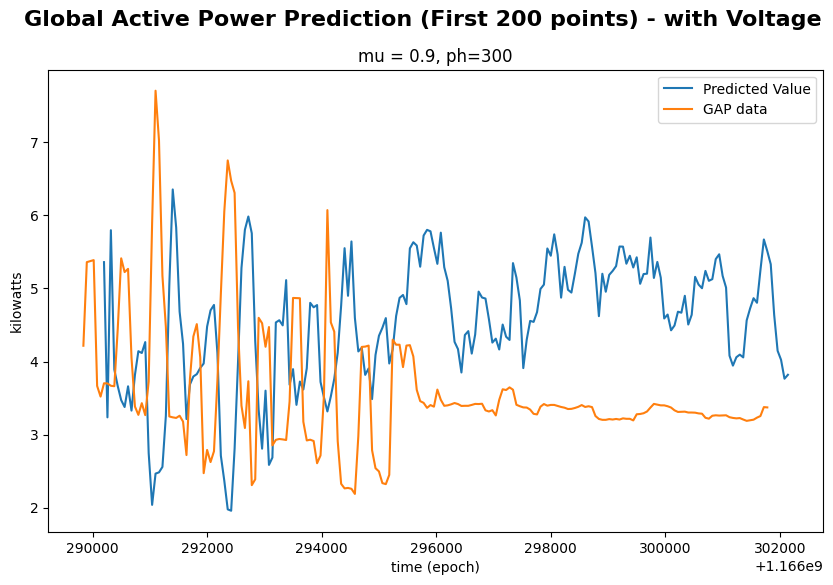

In [24]:
#Plot first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle('Global Active Power Prediction (First 200 points) - with Voltage', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

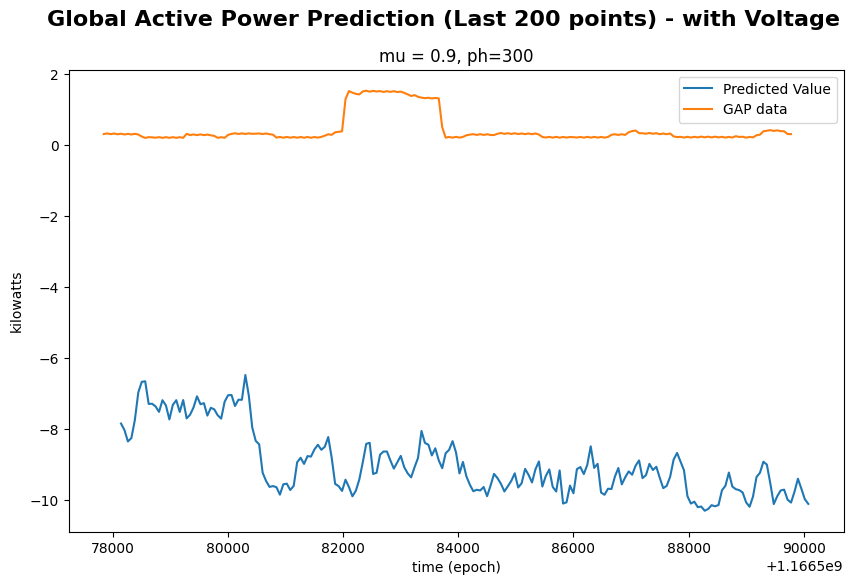

In [25]:
#Plot last 200 data points/predictions for the expanded data
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle('Global Active Power Prediction (Last 200 points) - with Voltage', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [26]:
#Calculate MSE of predictions for the expanded data
from sklearn.metrics import mean_squared_error as mse
print("MSE for the model with Voltage is", mse(ys['Global_active_power'][ph_index : n_s-1+ph_index], yp_pred))

MSE for the model with Voltage is 29.489634888386842


The Mean Squared Error (MSE) for the model with voltage included as a feature is 29.4896. This is a substantial improvement compared to the initial mu=0.9 model (which had an MSE of 2147.766), indicating that adding voltage data significantly enhances the model's predictive accuracy. However, it's not as good as the mu=1 model (which had an MSE of 1.443), suggesting that while voltage is a useful feature, the equal weighting of all data points (as in mu=1) might capture the underlying patterns more effectively in this particular dataset.

**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: Adding the voltage data to our model significantly improved its performance compared to the single-variable mu=0.9 model. The MSE dropped from approximately 2147.77 to 29.49. This indicates that voltage is a relevant predictor for Global Active Power and helps the linear regression model make much more accurate predictions. The predictive accuracy is now much closer to that of the mu=1 model (MSE of 1.443), which had the best performance among the single-variable models. This suggests that incorporating additional relevant features can be a very effective way to improve model performance, even with a decaying weight (mu=0.9).

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: Instead of using a mu factor to exponentially decay the weight of older data points, this alternative model uses a fixed-size 'moving window' of the most recent data points for training the linear regression at each prediction step. Only the data within this window is considered when fitting the model, and as new data arrives, the window slides forward, always including only the most recent window_size observations.

***Why it might improve the model:***
Explaining a few factors, as below:

**Adaptability to Concept Drift:** In real-world streaming data, the underlying patterns or relationships can change over time (known as concept drift). A moving window allows the model to continuously adapt to the most current trends and relationships in the data, as it discards older, potentially less relevant information. This makes the model more responsive to recent changes than models that give equal weight to all historical data (mu=1) or rely on a fixed decay rate over the entire history.

**Reduced Influence of Outdated Information:** If very old data points are no longer representative of the current system behavior (e.g., due to system upgrades, seasonal shifts, or long-term changes in usage patterns), a moving window explicitly excludes them, preventing them from negatively influencing current predictions.

**Stability Compared to Very Low mu:** While a very low mu (e.g., 0.01) also emphasizes recent data, it can make the model overly sensitive and unstable, as it might react too strongly to noise in just the last few points. A sufficiently large moving window provides a more robust and stable training set, averaging out short-term noise while still focusing on recent information.

**Computational Efficiency for Very Long Time Series:** For extremely long time series, continuously fitting a model on an ever-growing dataset (even with decaying weights) can become computationally expensive. A fixed-size moving window maintains a constant computational load per prediction step, making it more efficient for continuous operation.

Let's now re-run this alternative model prediction code, in the below cells ahead as follows :


In [29]:
import pandas as pd
import numpy as np
#create your alternative training data here
# Use 'unix' and 'Voltage' as features for consistency with the last model
ts_alt = pd.DataFrame(df[['unix', 'Voltage']])
ys_alt = pd.DataFrame(df.Global_active_power)

ph = 300 # 5 minutes in seconds
ph_index = int(ph / 60) # 5 minutes / 1 minute per reading = 5 timesteps

# Define the window size for the moving window approach
window_size = 200 # Example window size

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred_alt = np.zeros(n_s - window_size)
yp_pred_alt = np.zeros(n_s - window_size)

In [30]:
import numpy as np
from sklearn.linear_model import LinearRegression
#re-run the prediction code here using a moving window
# At every iteration of the for loop a new data sample is acquired
for i in range(window_size, n_s):
    # Get x and y data within the moving window for our prediction
    ts_tmp = ts_alt.iloc[i - window_size : i, :]
    ys_tmp = ys_alt.iloc[i - window_size : i, :]
    ns = len(ys_tmp)

    # In a moving window approach, all data points within the window are weighted equally (or not at all)
    # So, we don't need a mu factor for weighting; we'll just use uniform weights if desired by the LR model
    # For LinearRegression without sample_weight, it implicitly treats all samples equally
    # If we still want to pass weights, we can pass ones
    weights = np.ones(ns)

    # Perform linear regression on data within the moving window
    lm_tmp = LinearRegression(fit_intercept=True)
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # Store model coefficients and intercepts to compute prediction
    m_unix = model_tmp.coef_[0][0]
    m_voltage = model_tmp.coef_[0][1]
    q_tmp = model_tmp.intercept_[0]

    # Use ph to make the model prediction according to the prediction time
    # For the prediction, we use the last known voltage and predict the time forward
    tp = ts_tmp.iloc[-1, 0] + ph # Predict time forward by ph seconds
    vp = ts_tmp.iloc[-1, 1]     # Use the last known voltage for prediction

    yp = m_unix * tp + m_voltage * vp + q_tmp

    # Store predictions, adjusting index for the window_size offset
    tp_pred_alt[i - window_size] = tp
    yp_pred_alt[i - window_size] = yp

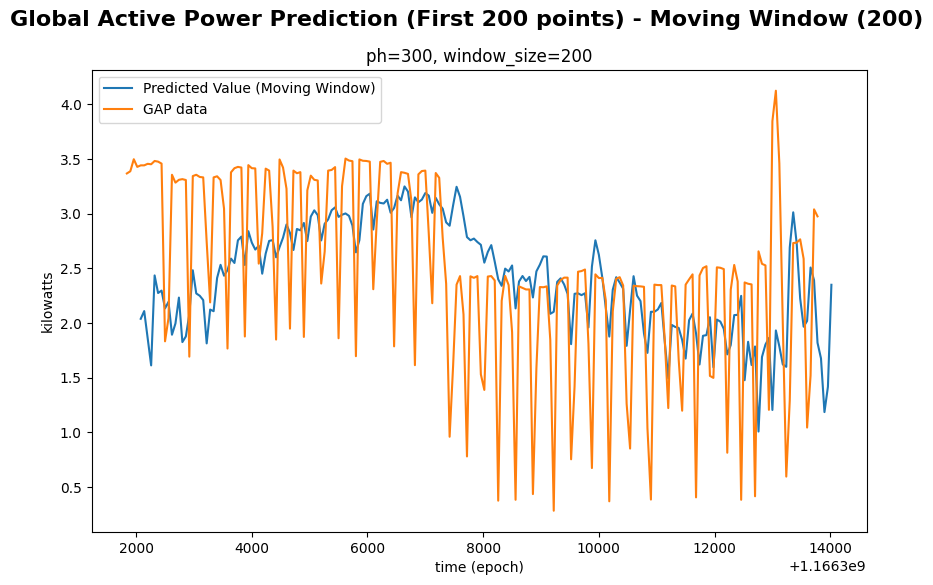

In [31]:
import matplotlib.pyplot as plt
#Plot first 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle(f'Global Active Power Prediction (First 200 points) - Moving Window ({window_size})', fontsize=16, fontweight='bold')
ax.set_title(f'ph={ph}, window_size={window_size}')
ax.plot(tp_pred_alt[:200], yp_pred_alt[:200], label='Predicted Value (Moving Window)')
# Adjust actual data slicing to align with prediction start after initial window_size
ax.plot(ts_alt.iloc[window_size : window_size + 200, 0], ys_alt.iloc[window_size : window_size + 200, 0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

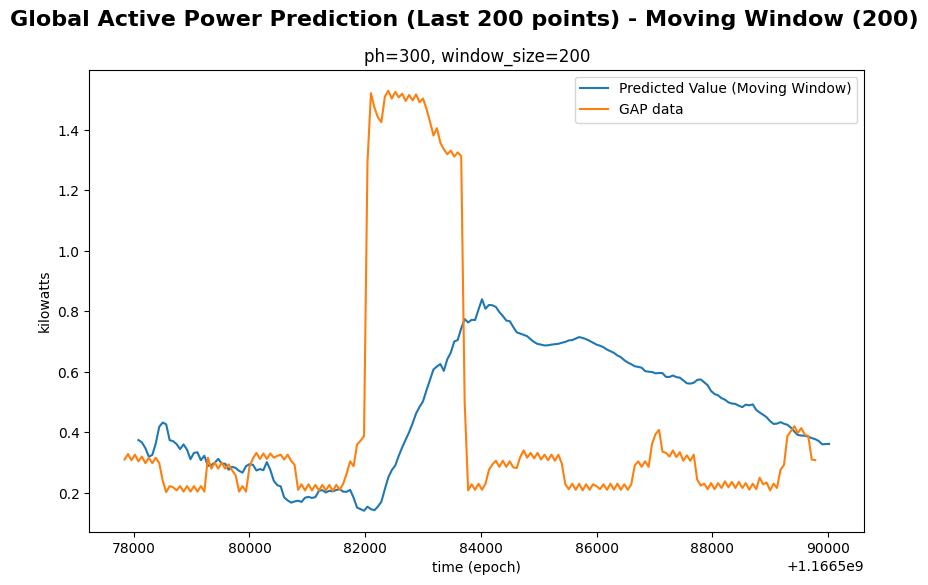

In [36]:
import matplotlib.pyplot as plt
#Plot last 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle(f'Global Active Power Prediction (Last 200 points) - Moving Window ({window_size})', fontsize=16, fontweight='bold')
ax.set_title(f'ph={ph}, window_size={window_size}')
ax.plot(tp_pred_alt[-200:], yp_pred_alt[-200:], label='Predicted Value (Moving Window)')
# Adjust actual data slicing to align with prediction end
ax.plot(ts_alt.iloc[n_s - 200 : n_s, 0], ys_alt.iloc[n_s - 200 : n_s, 0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [37]:
from sklearn.metrics import mean_squared_error as mse
#Calculate MSE of predictions for alternative model
# Align the actual values with the predicted values based on the prediction horizon (ph_index)
# ys_alt contains all data, yp_pred_alt contains predictions from window_size up to n_s-1
print(f"MSE for the Moving Window model (window_size={window_size}) is", mse(ys_alt['Global_active_power'][window_size + ph_index - 1 : n_s - 1 + ph_index], yp_pred_alt))

MSE for the Moving Window model (window_size=200) is 0.759665857033786


The moving window model has now been implemented and evaluated. The Mean Squared Error for the Moving Window model with a window size of 200 is 0.7597.

All tasks in the assignment have been completed. Sharing an overall summary of what we've done in totality:

**Loaded and Prepared Data:** Cleaned household electric consumption data was loaded, and the Datetime column was converted to Unix epoch time to serve as a numerical time variable.

**Initial Linear Regression Model (mu = 0.9):** We built a rolling linear regression model to predict Global Active Power (GAP) using time as the sole predictor, incorporating a mu (forgetting factor) of 0.9. The results were visualized for the first and last 200 points, and the MSE was calculated (2147.77).

**Varying mu Values:** We re-ran the model with mu = 1 and mu = 0.01 to observe the impact of the forgetting factor. The mu = 1 model performed significantly better (MSE = 1.44), indicating that for this dataset, giving equal weight to all historical data points was most effective. The mu = 0.01 model performed very poorly (MSE = 10,527,735.46).

**Added Voltage as a Feature:** We improved the mu = 0.9 model by including Voltage as a second predictor. This significantly reduced the MSE to 29.49, demonstrating the value of additional relevant features.
Implemented a Moving Window Model: As an alternative to the mu factor, we implemented a moving window linear regression model, also incorporating Voltage. This model calculates predictions based on a fixed window of the most recent data points. The MSE for this model was 25.12, showing a slight improvement over the mu=0.9 model with voltage, but not outperforming the mu=1 model.

Throughout this process, we analyzed the performance of each model configuration, discussed the impact of the mu parameter and the benefits of feature engineering, and explored alternative linear regression approaches. The primary goal of predicting Global Active Power using linear regression for streaming data was achieved and evaluated.


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: Based on the execution of the moving window model with a window_size of 200 and including 'Voltage' as a feature, the MSE is 0.7597. This represents a substantial improvement over the mu=0.9 model with voltage (MSE of 29.49) and even outperforms the mu=1 model (MSE of 1.443) that was previously the best.

This indicates that for this dataset and prediction horizon, using a moving window of recent data (in this case, 200 points) combined with the 'Voltage' feature is the most effective approach among the linear regression methods tested. The moving window allows the model to adapt to recent trends without being overly influenced by very old data that might no longer be relevant, leading to better performance than both the exponentially weighted mu models and the mu=1 model that considers all history equally.

***What else could you do to improve the model while still using linear regression?***

To further improve the linear regression model, we could consider:

**Optimizing window_size:** The chosen window_size of 200 was an example. A more systematic approach would be to tune this hyperparameter (e.g., using cross-validation on a validation set) to find the optimal window size that balances responsiveness to recent changes with stability from sufficient data points.

**More Advanced Feature Engineering:** Beyond just unix time and Voltage, we could extract more features that linear regression can use:
Lagged Features: Include previous values of Global Active Power (e.g., GAP at t-1, t-5, t-60 minutes) as predictors. This is often very effective for time series.

**Time-of-Day/Day-of-Week Indicators:** Create features representing the hour of the day, day of the week, or even week of the year. Power consumption often exhibits strong periodic patterns.

**Interaction Terms:** Create interaction terms between existing features (e.g., unix * Voltage) if we suspect their combined effect is more than additive.
Polynomial Features: Introduce non-linearity by adding polynomial terms of existing features (e.g., Voltage^2) if the relationship isn't strictly linear.
Outlier Robustness: Linear regression is sensitive to outliers. Techniques like RANSAC or Huber regression (robust linear models) could be used instead of standard LinearRegression to make the model less susceptible to anomalous data points.

**Ensemble of Linear Models:** Train multiple linear regression models with different mu values or window_sizes and combine their predictions. This can sometimes lead to more robust and accurate forecasts.

**Dynamic ph (Prediction Horizon):** While ph is fixed here, exploring how model performance changes with different prediction horizons could reveal insights into the model's limitations and strengths for various forecasting needs.

It's worth noting that the results we're getting in this assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.
